
# Casusopdracht: definitieve data science pipeline

Dit onderzoek is gedaan op verzoek van de Hogeschool Utrecht voor het vak Computational Modelling, er moest op basis van een gekregen dataset een onderzoekvraag worden beantwoord. In dit onderzoek gaan we via een supervised learning model de vraag beantwoorden. We gaan data verzamlen en kijken analyseren, het opschonen van deze data om uiteindelijk correlaties te vinden tussen verschillende datapunten. We passen machine-learning toe om de onderzoeksvraag te beantwoorden en data te voorspellen. Hieruit zouden we conclusies kunnen trekken over onze dataset. Dit onderzoek is gepleegd door Adam Chebil

De hiervoor vermelde onderzoeksvraag luid: In hoeverre is de prijs van een speler te voorspellen aan de hand van zijn belangrijkste kenmerken?

De dataset bestaan uit een CSV bestand met meerdere attributen en karakteristieken over voetbal spelers. Attributen zoals club, salaris en fysieke eigenschappen. 




In [1]:
# importeren van libaries.
import pandas as pd
import numpy as np
import os
from matplotlib import pyplot as plt
import altair as alt
from scipy import stats
import seaborn as sns
from scipy.integrate import quad
import scipy
import statistics
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from scipy.cluster.vq import whiten

# Data Collection

Eerst gaan we kijken naar de data en een beter begrip vormen voor dat we aan de dataset aan de slag gaan. Om hiermee te beginnen moeten we eerst de data verzamelen. Dit doen we door de ruwe data te importeren. De data is al gegeven en verzameld, maar nog niet opgeschoont.

In [2]:
# Het inladen van de datasets.
Dataset_1_not_cleaned = pd.read_csv('fifa19.csv')
Dataset_1_not_cleaned.head()

,Unnamed: 0,ID,Name,Age,Photo,Nationality,Flag,Overall,Potential,Club,...,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause
0,0,158023,L. Messi,31,https://cdn.sofifa.org/players/4/19/158023.png,Argentina,https://cdn.sofifa.org/flags/52.png,94,94,FC Barcelona,...,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0,€226.5M
1,1,20801,Cristiano Ronaldo,33,https://cdn.sofifa.org/players/4/19/20801.png,Portugal,https://cdn.sofifa.org/flags/38.png,94,94,Juventus,...,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0,€127.1M
2,2,190871,Neymar Jr,26,https://cdn.sofifa.org/players/4/19/190871.png,Brazil,https://cdn.sofifa.org/flags/54.png,92,93,Paris Saint-Germain,...,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0,€228.1M
3,3,193080,De Gea,27,https://cdn.sofifa.org/players/4/19/193080.png,Spain,https://cdn.sofifa.org/flags/45.png,91,93,Manchester United,...,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0,€138.6M
4,4,192985,K. De Bruyne,27,https://cdn.sofifa.org/players/4/19/192985.png,Belgium,https://cdn.sofifa.org/flags/7.png,91,92,Manchester City,...,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0,€196.4M


# Data exploration & analysis

Eerst gaan we grondig kijken naar onze dataset om wat conclusies te trekken en zodat we weten waar we aantoe zijn. We gaan eerst kijken naar de .info() van de dataset

In [3]:
Dataset_1_not_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18207 entries, 0 to 18206
Data columns (total 89 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Unnamed: 0                18207 non-null  int64  
 1   ID                        18207 non-null  int64  
 2   Name                      18207 non-null  object 
 3   Age                       18207 non-null  int64  
 4   Photo                     18207 non-null  object 
 5   Nationality               18207 non-null  object 
 6   Flag                      18207 non-null  object 
 7   Overall                   18207 non-null  int64  
 8   Potential                 18207 non-null  int64  
 9   Club                      17966 non-null  object 
 10  Club Logo                 18207 non-null  object 
 11  Value                     18207 non-null  object 
 12  Wage                      18207 non-null  object 
 13  Special                   18207 non-null  int64  
 14  Prefer

Zoals we zein zitter er 18207 rijen aan data met 89 kolommen. De type kolommen bevatten kwantitatieve (int of float) van 44 kolommen en nominale variabelen (object) van 45 kollomen. Bij verschillende soorten supervised learning algoritmes (zoals decision trees in sklearn) kan er alleen gebruik gemaakt worden van kwantitatieve variablen, daarvoor zullen we dus in de data processing sectie de dataset onderscheidne in kwantitatieve variablen en nominale variablen. 

Hierin zien we ook dat er aardig wat verschil is tussen het aantal 'non-null' entries zitten tussen de kolommen. Al is dat minder het geval bij alleen de kwantitatieve kolommen. Het laat zien dat het nodig zal zijn om rijen te verwijderen met zulke NaN entries. Dit kunnen we het beste doen na het bepalen welke kolommen gebruikt zullen worden voor het model. hierdoor verwijderen we geen rijen die alleen NaN values hebben in kolommen die we niet gebruiken.

Als we kijken naar de onderzoeksvraag zien we dat de 'Value' kolom de variable is daar we op willen trainen. Maar we weten nog niet welke andere kolommen bruikbaar zijn voor ons model. Om te beginnen zullen we eerst assessen welke variables een correlatie hebben met de target variable. Hier zullen we dus eerst een correaltie-lijst maken, dat een lijst is van correlatie-coefficienten tussen elke kwantitatieve variable en de target variablen.

Daarna zullen we een correlatie matrix maken van alle kwantitatieve variabelen dat een bruikbare correlatie hadden met de target variable. We zullen hiermee kijken welke variablen een extreem hoge correlatie hebben met elkaar.

Om dit te kunnen doen moeten we Value eerst omzetten in een ordinale variabelen. Deze waarden zijn cijfers maar in string vorm, dus laten we ze naar ints omzetten maar de grootte bewaren.

We zullen daarna ook met wat scatterplots de correlatie tonen, en daarna met boxplots laten zien of er outliers zien die er verwijdert kunnen worden.

In [4]:
Dataset_1_not_cleaned = pd.read_csv('fifa19.csv')

# Het filteren van kwantitatieve variablen.
dataset_kwan = []
dataset_nom = []
dfcopy = Dataset_1_not_cleaned
for col in Dataset_1_not_cleaned.columns: 
    if Dataset_1_not_cleaned[col].dtypes != "object":
        dataset_kwan.append(col)

# Zet de cijfers van value om in echte cijfers
valuenrs = np.unique(dfcopy['Value'])
valueints = []
for i in valuenrs:
    if i[-1] == 'M':
        valueints.append(float(i[1:-1]) * 1000000)
    elif i[-1] == 'K':
        valueints.append(float(i[1:-1]) * 1000)
    else:
        valueints.append(0)

# laat elke int 'value' corresponderen met elke string 'value'
valuenrs2 = dfcopy['Value']
valuenrs2 = valuenrs2.replace(valuenrs, valueints)

# voeg de nieuwe variable toe aan de dataset
dfcopy['Value-num'] = valuenrs2
dataset_kwan.append('Value-num')

# Meet hoeveel correlatie er is tussen de target variable en elke feature variable
dfcopy[dataset_kwan].corr()['Value-num'].sort_values()



Unnamed: 0                 -0.522014
ID                         -0.138194
Jersey Number              -0.095132
GKKicking                  -0.030923
GKHandling                 -0.028894
GKDiving                   -0.028596
GKReflexes                 -0.028544
GKPositioning              -0.027892
Age                         0.075022
SlidingTackle               0.087735
StandingTackle              0.108402
Balance                     0.113726
Jumping                     0.124515
Strength                    0.128924
Marking                     0.133862
Interceptions               0.140666
Weak Foot                   0.165221
Acceleration                0.170603
SprintSpeed                 0.172677
HeadingAccuracy             0.184437
Aggression                  0.184639
Agility                     0.194259
Stamina                     0.210721
Penalties                   0.239033
Crossing                    0.249785
Finishing                   0.256665
Positioning                 0.259391
F

We zien hier dat variable zoals Overall, poteential en international reputations de grootste correlatie hebben met de target variable. Omdat de target variable niet en continue maar een discrete variable is kunnen we geen correcte assessment maken over de precisie van de correlatie coefficient. We zullen een r>0.30 nemen als bruikbare feature variablen.

In [5]:
featurevar = ['Skill Moves','ShortPassing',
              'Vision','Special','Composure','Reactions','Potential','Overall' 
              ,'International Reputation', 'Value-num', 'Value']

print(dfcopy[featurevar].info())
dfcopy[featurevar]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18207 entries, 0 to 18206
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Skill Moves               18159 non-null  float64
 1   ShortPassing              18159 non-null  float64
 2   Vision                    18159 non-null  float64
 3   Special                   18207 non-null  int64  
 4   Composure                 18159 non-null  float64
 5   Reactions                 18159 non-null  float64
 6   Potential                 18207 non-null  int64  
 7   Overall                   18207 non-null  int64  
 8   International Reputation  18159 non-null  float64
 9   Value-num                 18207 non-null  float64
 10  Value                     18207 non-null  object 
dtypes: float64(7), int64(3), object(1)
memory usage: 1.5+ MB
None


,Skill Moves,ShortPassing,Vision,Special,Composure,Reactions,Potential,Overall,International Reputation,Value-num,Value
0,4.0,90.0,94.0,2202,96.0,95.0,94,94,5.0,110500000.0,€110.5M
1,5.0,81.0,82.0,2228,95.0,96.0,94,94,5.0,77000000.0,€77M
2,5.0,84.0,87.0,2143,94.0,94.0,93,92,5.0,118500000.0,€118.5M
3,1.0,50.0,68.0,1471,68.0,90.0,93,91,4.0,72000000.0,€72M
4,4.0,92.0,94.0,2281,88.0,91.0,92,91,4.0,102000000.0,€102M
...,...,...,...,...,...,...,...,...,...,...,...
18202,2.0,49.0,52.0,1307,45.0,49.0,65,47,1.0,60000.0,€60K
18203,2.0,43.0,33.0,1098,42.0,40.0,63,47,1.0,60000.0,€60K
18204,2.0,38.0,43.0,1189,41.0,47.0,67,47,1.0,60000.0,€60K
18205,2.0,42.0,47.0,1228,46.0,21.0,66,47,1.0,60000.0,€60K


Hieronder zien we de correlatie tussen de feature variablen van de top 4 continuous variables die het meeste correlatie hadden met de target variable. We zien dat ze inderdaad ook een correlatie met elkaar bevatten maar niet groot genoeg om te zeggen dat ze sommige redundant zijn.

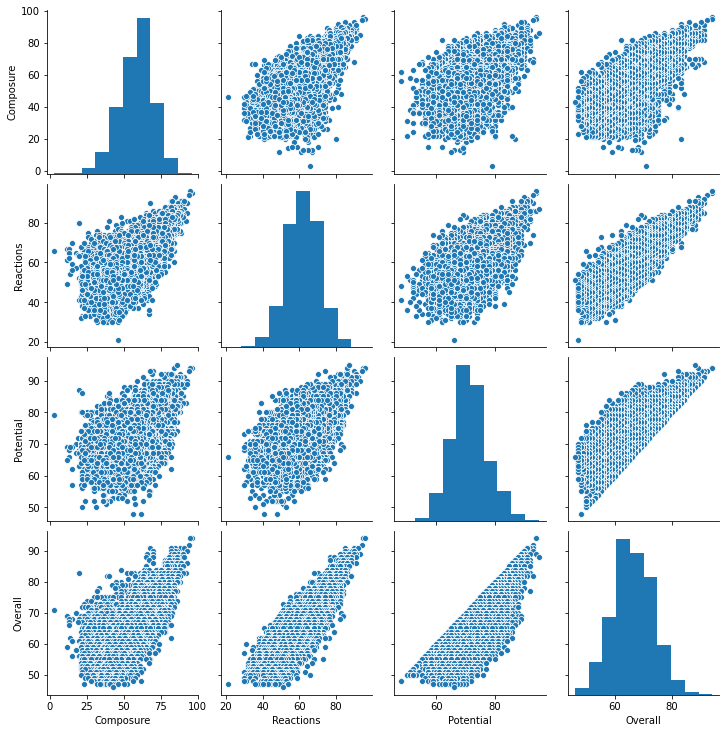

In [6]:
sns.pairplot(dfcopy[featurevar[4:-3]])


In [7]:
dfcopy[featurevar].corr()

,Skill Moves,ShortPassing,Vision,Special,Composure,Reactions,Potential,Overall,International Reputation,Value-num
Skill Moves,1.000000,0.730363,0.674057,0.763412,0.586836,0.377044,0.354290,0.414463,0.208153,0.315651
ShortPassing,0.730363,1.000000,0.713524,0.906729,0.685137,0.483028,0.369189,0.502550,0.242803,0.327623
Vision,0.674057,0.713524,1.000000,0.761992,0.636280,0.502536,0.348141,0.498894,0.284600,0.357639
Special,0.763412,0.906729,0.761992,1.000000,0.752331,0.597169,0.383727,0.606960,0.292208,0.377738
Composure,0.586836,0.685137,0.636280,0.752331,1.000000,0.685558,0.440008,0.727655,0.392787,0.450352
Reactions,0.377044,0.483028,0.502536,0.597169,0.685558,1.000000,0.513425,0.850045,0.445614,0.540552
Potential,0.354290,0.369189,0.348141,0.383727,0.440008,0.513425,1.000000,0.660939,0.372993,0.576218
Overall,0.414463,0.502550,0.498894,0.606960,0.727655,0.850045,0.660939,1.000000,0.499491,0.627085
International Reputation,0.208153,0.242803,0.284600,0.292208,0.392787,0.445614,0.372993,0.499491,1.000000,0.653176
Value-num,0.315651,0.327623,0.357639,0.377738,0.450352,0.540552,0.576218,0.627085,0.653176,1.000000


Hieronder zien we ook wat scatterplots dat laat zien waarom er inderdaad een correlatie is tussen de voorgenoemde continous variablen en de target variable. Het is duidelijk te zien dat er vooral veel verschil te zien is wanneer de feature waardes hoog zijn. Daar is te zien dat des te hoger de waarde is, des te hoger de value van de speler is.

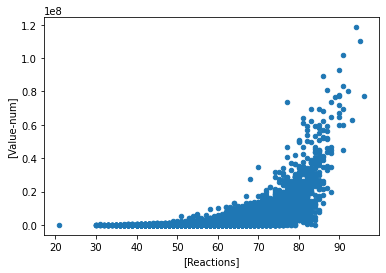

In [8]:
dfcopy.plot.scatter(x=[featurevar[-6]],y=['Value-num'])

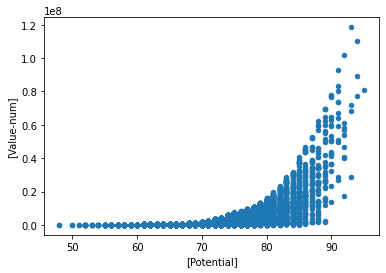

In [9]:
dfcopy.plot.scatter(x=[featurevar[-5]],y=['Value-num'])

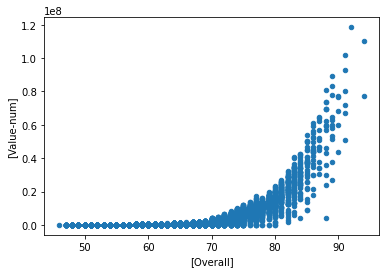

In [10]:
dfcopy.plot.scatter(x=[featurevar[-4]],y=['Value-num'])

# Data processing

We gaan in deze sectie de dataset aanpassen om klaar te maken voor gebruik. We zullen hier de data set aanpassen door het de verdelen tussen nominale en kwantitatieve variabelen en de kwantitiative variablen behouden. En dan deze uit deze datasets alleen de nodige kolommen uit halen die volgens de data analyse bruikbaar waren voor het model. Deze dataset is ook in volgorde van featurevariable van minst tot meeste correlatie tussen de targetvariable. De targetvariable zijn de laatste 2 kolommen in de processed dataset.

In [11]:
dfprocessed = pd.read_csv('fifa19.csv')

# Het filteren van kwantitatieve variablen.
dataset_kwan = []
dataset_nom = []
for col in dfprocessed.columns: 
    if dfprocessed[col].dtypes != "object":
        dataset_kwan.append(col)

dfprocessed['Value-num'] = valuenrs2
dfprocessed = dfprocessed[featurevar]
dfprocessed

,Skill Moves,ShortPassing,Vision,Special,Composure,Reactions,Potential,Overall,International Reputation,Value-num,Value
0,4.0,90.0,94.0,2202,96.0,95.0,94,94,5.0,110500000.0,€110.5M
1,5.0,81.0,82.0,2228,95.0,96.0,94,94,5.0,77000000.0,€77M
2,5.0,84.0,87.0,2143,94.0,94.0,93,92,5.0,118500000.0,€118.5M
3,1.0,50.0,68.0,1471,68.0,90.0,93,91,4.0,72000000.0,€72M
4,4.0,92.0,94.0,2281,88.0,91.0,92,91,4.0,102000000.0,€102M
...,...,...,...,...,...,...,...,...,...,...,...
18202,2.0,49.0,52.0,1307,45.0,49.0,65,47,1.0,60000.0,€60K
18203,2.0,43.0,33.0,1098,42.0,40.0,63,47,1.0,60000.0,€60K
18204,2.0,38.0,43.0,1189,41.0,47.0,67,47,1.0,60000.0,€60K
18205,2.0,42.0,47.0,1228,46.0,21.0,66,47,1.0,60000.0,€60K


# Data cleaning

We zullen nu met de overgebleven data gaan werken om het op te schonen. Dit houd vooral in dat we NaN/none values verwijderen en outliers gaan onderzoeken. 

Eerst gaan we kijken of het mogelijk is om elke row met NaN values te verwijderen zonder dat de dataset te klein hierdoor word. Als dat niet zo is verwijderen we alle rows met NaN values.

Daarna zullen we de outliers verwijderen met behulp van een zscore.

In [12]:
print(len(dfprocessed) - (len(dfprocessed) - len(dfprocessed.dropna())))
# Alleen 48 rijen worden verwijdert van de bijna 20,000

18159


In [13]:
dfprocessed = dfprocessed.dropna()

In [14]:
z_scores = stats.zscore(dfprocessed[featurevar[:-2]])
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 1.3).all(axis=1)
dfcleaned = dfprocessed[filtered_entries]
dfcleaned

,Skill Moves,ShortPassing,Vision,Special,Composure,Reactions,Potential,Overall,International Reputation,Value-num,Value
1586,2.0,68.0,45.0,1628,66.0,70.0,78,75,1.0,7000000.0,€7M
1598,3.0,74.0,65.0,1868,72.0,69.0,75,75,1.0,4500000.0,€4.5M
1604,3.0,70.0,62.0,1911,69.0,71.0,75,75,1.0,4800000.0,€4.8M
1605,2.0,75.0,67.0,1728,67.0,70.0,75,75,1.0,5000000.0,€5M
1615,2.0,66.0,47.0,1751,66.0,69.0,75,75,1.0,4900000.0,€4.9M
...,...,...,...,...,...,...,...,...,...,...,...
16248,2.0,69.0,52.0,1550,47.0,60.0,70,58,1.0,210000.0,€210K
16253,2.0,54.0,55.0,1434,44.0,52.0,68,58,1.0,210000.0,€210K
16260,2.0,62.0,58.0,1561,56.0,54.0,65,58,1.0,180000.0,€180K
16262,2.0,66.0,66.0,1498,61.0,56.0,78,58,1.0,260000.0,€260K


Geen uitschieters meer: 


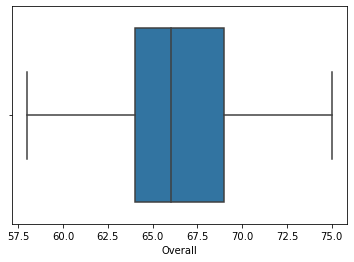

In [15]:
sns.boxplot(dfcleaned['Overall'])
print("Geen uitschieters meer: ")

# Baseline
Hier gaan we beginnen met een simpel begin van het model. Hierin gaan we nog niet kijken naar hyperparamaters, de trainset grootte, en beginnen we alleen met een decisiontree model. We hebben ook nog niet de data genormaliseerd.

In [16]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [17]:
# kiezen van model
model = DecisionTreeClassifier()

#Organiseer de data
feats = np.array(dfcleaned[featurevar[:-2]])
cat = dfcleaned['Value']

#Creëer een train- en validatieset
feats_train, feats_test, cat_train, cat_test = train_test_split(feats, cat, random_state=10)
#train het model
model.fit(feats_train, cat_train)
#valideer het model
model.score(feats_test, cat_test)

0.33181357649442755

We zien dat het gebruiken van een decision tree best een lage score geeft. We kunnen dit misschien verbeteren door een ander model te gebruiken.



In [18]:
# kiezen van model
model = LinearRegression()

#Organiseer de data
feats = np.array(dfcleaned[featurevar[:-2]])
cat = dfcleaned['Value-num']

#Creëer een train- en validatieset
feats_train, feats_test, cat_train, cat_test = train_test_split(feats, cat, random_state=10)
#train het model
model.fit(feats_train, cat_train)
#valideer het model
model.score(feats_test, cat_test)

0.6551486959164755

We zien meteen dat Linear regression een 2 keer hogere score geeft. We gaan nu kijken of we deze score iets hoger kunnen zetten. Eerst gaan we kijken of de train_set kunnen verhogen om betere resultaten te leveren.

In [19]:
#Creëer een train- en validatieset
feats_train, feats_test, cat_train, cat_test = train_test_split(feats, cat,test_size = 0.09,
                                                                random_state=10)
#train het model
model.fit(feats_train, cat_train)
#valideer het model
model.score(feats_test, cat_test)

0.6728323708760344

Het is te zien dat de score hier inderdaad meer mee omhoog gaat. Met dit model kunnen we de verwachte waarde van een speler voorspellen met bijna 70% accuratie. Als we kijken naar de variablen die het meeste invloed hebben op deze voorspellingen kunnen we ook wel zien waarom dat gebeurt. Variablen zoals Potential, Overall, International Reputation hebben de meeste correlatie. In voetbal is het natuurlijk erg belangrijk dat iemand goed presteerd, en met een goeie prestatie kom je ook hoger in reputatie, wat dus betekent dat het niet zo raar is dat iemand zijn reputatie de waarde van de speler reflecteerd.

Het zelfde geld voor potentie en skill moves, Deze attributen maken een speler ook beter in de sport en dus meer gewild. Wat dus dan ook hun waarde verhoogt. 

We kunnen ook kijken naar variable die we niet hebben gebruikt zoals Age. Je zou denken dat de leeftijd veel invloed zou hebben op een speler zijn waarde. Maar je zou kunnen bedenken dat jonge en oude spelers beide goede en slechte kanten kunnen hebben. jonge spelers hebben misschien wel een gezonder lichaam, maar hebben ook vaak minder ervaring. Ook is gaan spelers vaak als snel met pentioen en wordt er vaak selectief gekeken naar iemands leeftijd voor ze mee mogen doen aan een club. Hier onstaat dan ook een bias in de data wat het minder bruikbaar maakt. 

Wat de data wel moeilijker maakt om te interpreteren is het idee dat voetbal vooral een amusement sport is. Wat dus kan betekenen dat hoe mensen een speler subjectief zien invloed kan hebben op zijn populariteit en dus ook zijn waarde. 

In conclusie, om de onderzoeksvraag te beantwoorden. Ja het is mogelijk om tenminste meer dan 2/3e van de tijd een speler zijn waarde te voorspellen op basis van zijn belangrijkste kenmerken. 
